#  Predicitive Modeling of Hourly Electricity Data 
## Regression is performed to predict hourly kilowatt-hour use 

## CONTENTS

1. Data Import
2. Exploratory Analysis
3. Preparation for Machine Learning Modeling
4. Linear Regression Model
5. Random Forest Regression
6. Extra Trees Regression
7. Support Vector Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
%matplotlib inline

import IPython.core.display as di
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

## Electricity Data

In [2]:
elec = pd.read_csv('elec_hourly_oldApt_2014-04-30.csv', parse_dates=True, index_col=0)
print ('Start of electricity data: ', min(elec.index))
print ('End of electricity data: ', max(elec.index))
elec.head(5)

Start of electricity data:  2014-01-18 00:00:00
End of electricity data:  2014-04-30 23:00:00


,COST,UNITS,USAGE,timestamp_end
timestamp,,,,
2014-01-18 00:00:00,NaN,kWh,1.13,1/18/2014 0:59
2014-01-18 01:00:00,NaN,kWh,0.98,1/18/2014 1:59
2014-01-18 02:00:00,NaN,kWh,0.94,1/18/2014 2:59
2014-01-18 03:00:00,NaN,kWh,1.11,1/18/2014 3:59
2014-01-18 04:00:00,NaN,kWh,1.34,1/18/2014 4:59


## Weather Data

In [3]:
weather = pd.read_csv('weather_2015-02-01.csv', parse_dates=True, index_col=0)
print ('Start of weather data: ', min(elec.index))
print ('End of weather data: ', max(elec.index))
weather.head()

Start of weather data:  2014-01-18 00:00:00
End of weather data:  2014-04-30 23:00:00


,hum,precipm,tempm,wspdm,tempF
timestamp,,,,,
2014-01-01 01:00:00,45.00,nan,-3.90,5.60,25.00
2014-01-01 02:00:00,43.00,nan,-3.90,14.80,25.00
2014-01-01 03:00:00,46.00,nan,-4.40,14.80,24.10
2014-01-01 04:00:00,46.00,nan,-4.40,14.80,24.10
2014-01-01 05:00:00,48.00,nan,-4.40,0.00,24.10


### Merging Electricty and Weather Data into one DataFrame

In [4]:
# Merge into one Pandas dataframe
elec_and_weather = pd.merge(weather, elec, left_index=True, right_index=True)

# Remove unnecessary fields from dataframe
del elec_and_weather['tempm'], elec_and_weather['COST'], elec_and_weather['UNITS']
del elec_and_weather['precipm']

# Convert windspeed to MPH for my feeble brain to interpret
elec_and_weather['wspdMPH'] = elec_and_weather['wspdm'] * 0.62
del elec_and_weather['wspdm']

print ('\nTotal number of observations: ', len(elec_and_weather),'\n')
elec_and_weather.head()


Total number of observations:  2470 



,hum,tempF,USAGE,timestamp_end,wspdMPH
timestamp,,,,,
2014-01-18 00:00:00,56.00,39.20,1.13,1/18/2014 0:59,4.59
2014-01-18 01:00:00,61.00,39.20,0.98,1/18/2014 1:59,4.59
2014-01-18 02:00:00,61.00,39.20,0.94,1/18/2014 2:59,4.59
2014-01-18 03:00:00,65.00,39.20,1.11,1/18/2014 3:59,4.59
2014-01-18 04:00:00,70.00,39.20,1.34,1/18/2014 4:59,4.59


## Generates Descriptive Statistics that summarize the Central Tendency, Dispersion and Shape of a Dataset's Distribution

In [5]:
elec_and_weather.describe()

,hum,tempF,USAGE,wspdMPH
count,2470.00,2470.00,2470.00,2470.00
mean,58.52,39.42,1.10,6.94
std,20.69,14.55,0.85,5.38
min,16.00,3.90,0.09,0.00
25%,42.25,28.22,0.31,3.47
50%,55.00,37.90,0.86,5.77
75%,75.00,50.00,1.84,10.35
max,100.00,82.90,3.16,29.88


## Plot of Energy Demand and Temperature Data (°F)

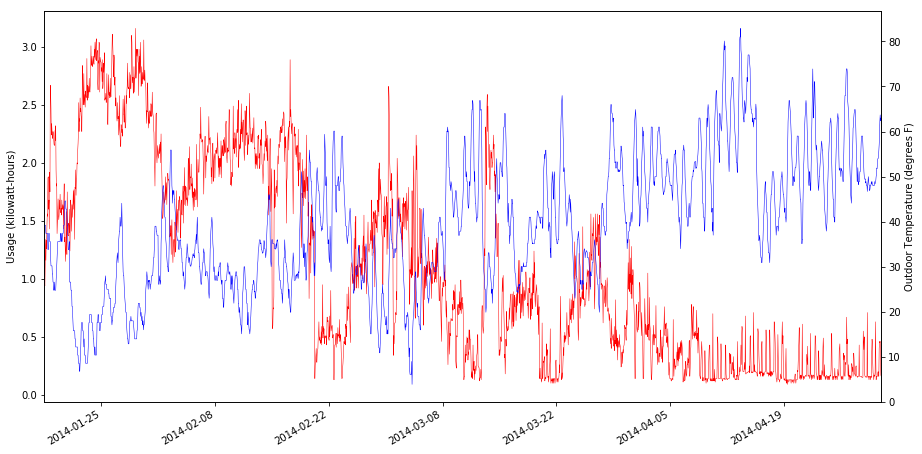

In [6]:
fig = plt.figure(figsize=[15,8])
ax1 = elec_and_weather['USAGE'].plot(label='asdf', color='r', linewidth=0.5)
ax2 = elec_and_weather['tempF'].plot(secondary_y = True, label='cew', color='b', linewidth=0.5)
ax1.set_xlabel('')
ax1.set_ylabel('Usage (kilowatt-hours)', fontsize=10)
ax2.set_ylabel('Outdoor Temperature (degrees F)', fontsize=10)
ax1.grid('off')

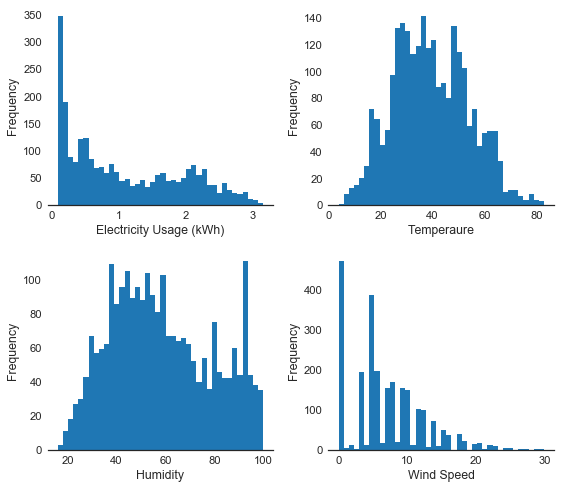

In [7]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.4) 
plt.figure(figsize=(8,7))

plt.subplot(2,2,1)
elec_and_weather['USAGE'].hist(bins=40, grid=False)
plt.xlabel('Electricity Usage (kWh)')
plt.ylabel('Frequency')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,2)
elec_and_weather['tempF'].hist(bins=40, grid=False)
plt.xlabel('Temperaure')
plt.ylabel('Frequency')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,3)
elec_and_weather['hum'].hist(bins=40, grid=False)
plt.xlabel('Humidity')
plt.ylabel('Frequency')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,4)
elec_and_weather['wspdMPH'].hist(bins=40, grid=False)
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
sns.despine(left=True)
plt.tight_layout()

** Temeperature and Humidity are normally distributed, while Electricity Usage and ind Speed are skewed right

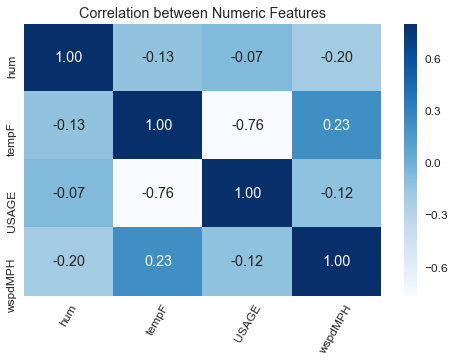

In [8]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.8)

corr = elec_and_weather.corr()
corr.loc[:,'USAGE'].abs().sort_values(ascending=False)[1:]
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(8,5))
a = sns.heatmap(corr, annot=True, fmt='.2f' ,vmax=.8, 
                linecolor="white", cmap="Blues")
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=60)
plt.title('Correlation between Numeric Features');

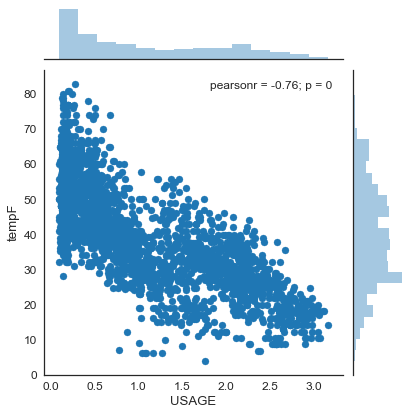

In [9]:
sns.jointplot(x=elec_and_weather['USAGE'],y=elec_and_weather['tempF']);

Temperature and Electricty usage have a negative correleation

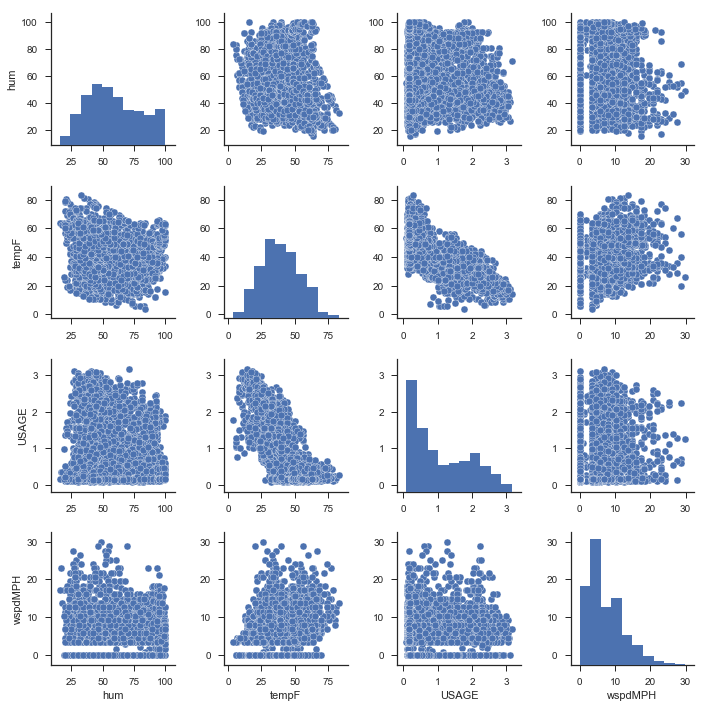

In [10]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

g = sns.pairplot(elec_and_weather)

### Create a New column to identify Weekends and Weekdays

In [11]:
## Set weekends and holidays to 1, otherwise 0
elec_and_weather['Weekend'] = np.zeros(len(elec_and_weather['USAGE']))

# Weekends
elec_and_weather['Weekend'][(elec_and_weather.index.dayofweek==5)|(elec_and_weather.index.dayofweek==6)] = 1

# Holidays, days I worked from home
holidays = ['2014-01-01','2014-01-20']
work_from_home = ['2014-01-21','2014-02-13','2014-03-03','2014-04-04']

for i in range(len(holidays)):
    elec_and_weather['Weekend'][elec_and_weather.index.date==np.datetime64(holidays[i])] = 1

for i in range(len(work_from_home)):
    elec_and_weather['Weekend'][elec_and_weather.index.date==np.datetime64(work_from_home[i])] = 1
 
elec_and_weather.head(5)

,hum,tempF,USAGE,timestamp_end,wspdMPH,Weekend
timestamp,,,,,,
2014-01-18 00:00:00,56.00,39.20,1.13,1/18/2014 0:59,4.59,1.00
2014-01-18 01:00:00,61.00,39.20,0.98,1/18/2014 1:59,4.59,1.00
2014-01-18 02:00:00,61.00,39.20,0.94,1/18/2014 2:59,4.59,1.00
2014-01-18 03:00:00,65.00,39.20,1.11,1/18/2014 3:59,4.59,1.00
2014-01-18 04:00:00,70.00,39.20,1.34,1/18/2014 4:59,4.59,1.00


## Box Plot and Strip Plot to Visualize Electricity Consumption on Weekends/Weekdays

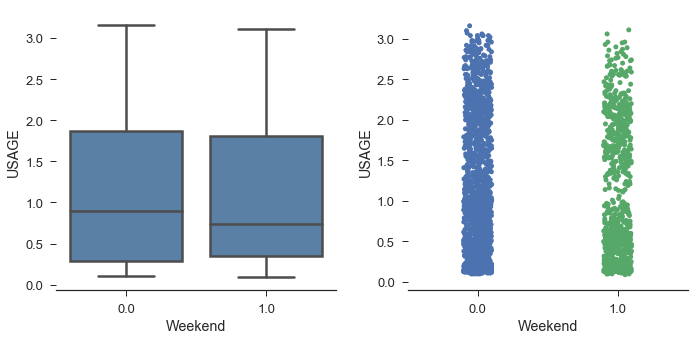

In [12]:
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(x="Weekend", y="USAGE", data=elec_and_weather, color='#4d80b3');
plt.ylabel('USAGE')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
ax = sns.stripplot(x="Weekend", y="USAGE", data=elec_and_weather, jitter=True)
sns.despine(left=True)
plt.tight_layout()

In [31]:
print (elec_and_weather.groupby(by='Weekend').mean()['USAGE'])

Weekend
0.00   1.11
1.00   1.08
Name: USAGE, dtype: float64


Generally, it is seen that on weekends and weekdays, there is only a slight difference in Electricity usage

### Create new column for each hour of day, assign 1 if index.hour is corresponding hour of column, 0 otherwise


In [13]:
# Create new column for each hour of day, assign 1 if index.hour is corresponding hour of column, 0 otherwise

for i in range(0,24):
    elec_and_weather[i] = np.zeros(len(elec_and_weather['USAGE']))
    elec_and_weather[i][elec_and_weather.index.hour==i] = 1
    
# Example 3am
elec_and_weather[3][:6]

timestamp
2014-01-18 00:00:00   0.00
2014-01-18 01:00:00   0.00
2014-01-18 02:00:00   0.00
2014-01-18 03:00:00   1.00
2014-01-18 04:00:00   0.00
2014-01-18 05:00:00   0.00
Name: 3, dtype: float64

## Appending with Historical Window of previous Electricity Demand

In [14]:
for obs in range(1,7):
    elec_and_weather["T_" + str(obs)] = elec_and_weather.USAGE.shift(obs)
    
elec_and_weather.fillna(0.00,inplace=True)
elec_and_weather.head(3)    

,hum,tempF,USAGE,timestamp_end,wspdMPH,Weekend,0,1,2,3,...,20,21,22,23,T_1,T_2,T_3,T_4,T_5,T_6
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-01-18 00:00:00,56.00,39.20,1.13,1/18/2014 0:59,4.59,1.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2014-01-18 01:00:00,61.00,39.20,0.98,1/18/2014 1:59,4.59,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.13,0.00,0.00,0.00,0.00,0.00
2014-01-18 02:00:00,61.00,39.20,0.94,1/18/2014 2:59,4.59,1.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.98,1.13,0.00,0.00,0.00,0.00


# Machine Learning Modeling for Electricty Usage Prediction

## Feature Scaling
Scaling Temperaure, humidity and Windspeed Columns between 0 and 1

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
elec_and_weather[['hum', 'tempF','wspdMPH']] = scaler.fit_transform(elec_and_weather[['hum', 'tempF','wspdMPH']]);

## Train Test Split

In [16]:
# Define training and testing periods
train_start = '18-jan-2014'
train_end = '29-march-2014'
test_start = '30-march-2014'
test_end = '15-april-2014'

In [ ]:
# Define training and testing periods
train_start = '18-jan-2014'
train_end = '24-march-2014'
test_start = '25-march-2014'
test_end = '31-march-2014'

In [17]:
# Split up into training and testing sets (still in Pandas dataframes)

X_train_df = elec_and_weather[train_start:train_end]
del X_train_df['USAGE']
del X_train_df['timestamp_end']
#del X_train_df['hum']
#del X_train_df['tempF']
#del X_train_df['wspdMPH']

y_train_df = elec_and_weather['USAGE'][train_start:train_end]

X_test_df = elec_and_weather[test_start:test_end]
del X_test_df['USAGE']
del X_test_df['timestamp_end']
#del X_test_df['hum']
#del X_test_df['tempF']
#del X_test_df['wspdMPH']

y_test_df = elec_and_weather['USAGE'][test_start:test_end]

In [18]:
print ('Number of observations in the Training set:', len(X_train_df))
print ('Number of observations in the Test set: ', len(X_test_df))

Number of observations in the Training set: 1702
Number of observations in the Test set:  408


The training set consists of 32 features, humidity, temperature, weekend/weekday, hour of the day(24 columns) and 06 columns for historic usage

## 1. Linear Regression Model

In [19]:
# Initialize and fit the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# R^2 (coefficient of determination) regression score function
# Mean squared error regression loss

benchmark_model = LinearRegression() #object of class LinearRegression

start = time()
benchmark_model.fit(X_train_df, y_train_df) #Fit object to training set
end = time()
y_pred=benchmark_model.predict(X_test_df)
print("Classifier fitted in {:.2f} seconds".format(end-start))
print("Score on Training data : {:.2f}%".format(benchmark_model.score(X_train_df, y_train_df) * 100))
print("Score on Testing data : {:.2f}%".format(benchmark_model.score(X_test_df, y_test_df) * 100))
print("RMSE : {:.3f}".format(np.sqrt(np.mean((y_test_df - y_pred)**2))))

Classifier fitted in 0.00 seconds
Score on Training data : 95.18%
Score on Testing data : 71.04%
RMSE : 0.128


## 2. Random Forest Regression Model

In [20]:
from sklearn.ensemble import RandomForestRegressor
randforest = RandomForestRegressor(n_estimators=10, random_state=0)

In [21]:
randforest.fit(X_train_df, y_train_df)
y_pred=randforest.predict(X_test_df)

In [22]:
print("Score on Training data : {:.2f}%".format(randforest.score(X_train_df, y_train_df) * 100))
print("Score on Testing data : {:.2f}%".format(randforest.score(X_test_df, y_test_df) * 100))
print("RMSE : {:.3f}".format(np.sqrt(np.mean((y_test_df - y_pred)**2))))

Score on Training data : 98.96%
Score on Testing data : 68.63%
RMSE : 0.134


## 3. ExtraTrees Regressor

In [23]:
from sklearn.ensemble import ExtraTreesRegressor
regr = ExtraTreesRegressor(n_estimators=10, random_state=0)

In [24]:
regr.fit(X_train_df, y_train_df)
y_pred=regr.predict(X_test_df)

In [25]:
print("Score on Training data : {:.2f}%".format(regr.score(X_train_df, y_train_df) * 100))
print("Score on Testing data : {:.2f}%".format(regr.score(X_test_df, y_test_df) * 100))
print("RMSE : {:.3f}".format(np.sqrt(np.mean((y_test_df - y_pred)**2))))

Score on Training data : 100.00%
Score on Testing data : 71.50%
RMSE : 0.127


## 4. Support Vector Regression

In [26]:
from sklearn.svm import SVR
clf = SVR(kernel='rbf', C=5, epsilon=0.2)
clf.fit(X_train_df, y_train_df) 
y_pred=clf.predict(X_test_df)

In [27]:
print("Score on Training data : {:.2f}%".format(clf.score(X_train_df, y_train_df) * 100))
print("Score on Testing data : {:.2f}%".format(clf.score(X_test_df, y_test_df) * 100))
print("RMSE : {:.3f}".format(np.sqrt(np.mean((y_test_df - y_pred)**2))))

Score on Training data : 95.48%
Score on Testing data : 70.23%
RMSE : 0.130


In [28]:
# Use SVR model to calculate predicted next-hour usage
predict_y_array = clf.predict(X_test_df)

# Put it in a Pandas dataframe for ease of use
predict_y = pd.DataFrame(predict_y_array,columns=['USAGE'])
predict_y.index = X_test_df.index

#### Based on R2 Scores ExtraTrees Regressor has the highest R2 Score on testing data and lowest RMSE Error. After this model Support Vector for Regression performs the best

## Plot of Predicted vs Actual

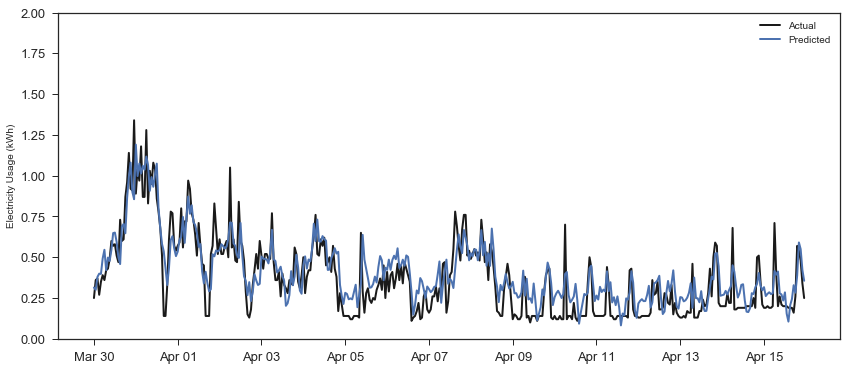

In [29]:
# Plot the predicted values and actual
import matplotlib.dates as dates

plot_start = test_start
plot_end = test_end

fig = plt.figure(figsize=[14,6])
ax = fig.add_subplot(111)
plt.plot(y_test_df.index,y_test_df,color='k',linewidth=2)
plt.plot(predict_y.index,predict_y,linewidth=2)
plt.ylabel('Electricity Usage (kWh)', fontsize=10)
plt.ylim([0,2])
plt.legend(['Actual','Predicted'],loc='best', fontsize=10)
ax.xaxis.set_major_formatter(dates.DateFormatter('%b %d'))
#fig.savefig('SVM_predict_TS.png')